In [1]:
# ! pip install --upgrade pip
# ! pip install --user numpy scipy matplotlib pyhf cabinetry uproot pandas

In [2]:
import numpy as np
import cabinetry
import pyhf
import json
import uproot
import pandas as pd
from pathlib import Path

cabinetry.__version__

'0.5.2'

# $B^+ \to K^+ \pi^0$ example 

Here we want to study the fitting of the $B^+ \to K^+ \pi^0$ channel, that you reconstructed in the basf2 workshop. There are some decisions to make before constructing a statistical model:

* **Fitting variable**: The choice of fitting variable is crucial. Ideally, one choses a variable where distributions of signal and background look very different. This gives more power to distinguish the two during the fitting procedure. Here we chose $\Delta E$, which is the difference between the energy of the $B$ and half the center of mass energy.

* **Binning**: The choice of binning is an important one. If the binning is too fine, we won't have enough statistics. If the binning is too wide, we lose information that might be important to us. In this example we chose a binning of 20 equally distributed bins in the range $-0.4 \geq \Delta E \geq 0.4$.

* **Samples**: We have to do a good job at modelling our data with MC samples. We include samples of different nature, to build a template. The benefit of keeping the samples separate is that we can modify them individually, and assign different modifiers to them. Here we made the following choice of samples:
  * **signal**: This includes the signal MC
  * **qqbar**: This includes $e^+e^- \to q \bar q$ background events, where we only include $s \bar s$ and $c \bar c$, as these are the dominant ones.
  * **BBbar**: This includes $B^+ B^-$ and $B^0 \bar B ^0$ background events.
  * **misID**: This includes events where the kaon is misidentified as pion.

# Building the model

We will use `Cabinetry` ([documentation](https://cabinetry.readthedocs.io/en/latest/)) to build our `pyhf` model. We will see, this comes with many convenience functions to make our life easier. For example, `Cabinetry` has the nice feature that it can crate `pyhf` models from `root` files. 

First we define the binning for our fitting variable.

In [3]:
bins = np.linspace(-0.4, 0.4, 20 + 1)

We define `cabinetry` models vie a `config` dictionary, containing different settings.

First, we give our measurement a name, define a parameter of interest (POI), and input path containing the `root` files and a histogram folder, where cabinetry automatically saves the histogram yields.

In [4]:
cabinetry.set_logging()

BASE = Path('ntuples')

config = {
   'General':{
      'Measurement': 'B2Kpi0',
      'POI': 'mu',
      'InputPath': str(BASE / '{SamplePath}'), # wildcard for samples
      'HistogramFolder': 'histograms/'

   }
}

Before we continue, we want to calculate the correct normalizations for the individual samples. Normally, one has to scale according to luminosity. Since we use MC to simulate data, we simplify our lives by comparing to the generic MC files and summing the event weights. Here we only use the PID weights in the `data_MC_ratio` entry, calculated using the [systematics framework](https://syscorrfw.readthedocs.io/en/latest/index.html). How we assign them and how their uncertainties are calculated is described in the `pid-weights.ipynb` notebook. If you have time at the end, feel free to have a look at the notebook.

First, let us load all the signal and background ntuples. We use a mix of reconstructed MC samples as the data in this example (charged and mixed $B \bar B$, $s \bar s$ and $c \bar c$).

In [5]:
with uproot.open({'ntuples/data_ssbar.root': 'B'}) as tree:
    dat_ssb = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/data_ccbar.root': 'B'}) as tree:
    dat_ccb = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/data_charged.root': 'B'}) as tree:
    dat_cha = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/data_mixed.root': 'B'}) as tree:
    dat_mix = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/signal.root': 'B'}) as tree:
    sig = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/ssbar.root': 'B'}) as tree:
    ssb = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/ccbar.root': 'B'}) as tree:
    ccb = tree.arrays(tree.keys(), library="pd")

with uproot.open({'ntuples/charged.root': 'B'}) as tree:
    cha = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/mixed.root': 'B'}) as tree:
    mix = tree.arrays(tree.keys(), library="pd")
    
with uproot.open({'ntuples/misID.root': 'B'}) as tree:
    mis = tree.arrays(tree.keys(), library="pd")

Before summing the weights for the corresponding samples, we apply additional cuts. We combine the $s \bar s$ and $c\bar c$ backgrounds to a common $q \bar q$ background and the charged and mixed $B \bar B$ to a common $B \bar B$ background. 

In [6]:
w = 'data_MC_ratio'

global_cuts = '(abs(B_deltaE)<0.4) & (B_R2<0.45) & (B_cosTBTO<0.8)'

signal_cuts = global_cuts + '& (B_isSignal==1)'
signal_norm = dat_cha.query(signal_cuts).sum()[w] / sig.query(signal_cuts).sum()[w]
print('signal norm:', signal_norm)

qqbar_cuts = global_cuts
qqbar_norm = (dat_ssb.query(global_cuts).sum()[w] + dat_ccb.query(global_cuts).sum()[w]) / (ssb.query(global_cuts).sum()[w] + ccb.query(global_cuts).sum()[w])
print('qqbar norm:', qqbar_norm)

BBbar_cuts = global_cuts + '& (B_mcErrors>0) & (B_mcErrors!=128)'
BBbar_norm = (dat_cha.query(BBbar_cuts).sum()[w] + dat_mix.query(BBbar_cuts).sum()[w]) / (cha.query(BBbar_cuts).sum()[w] + mix.query(BBbar_cuts).sum()[w])
print('BBbar norm:', BBbar_norm)

misID_cuts = global_cuts + '& (B_mcErrors==128)'
misID_norm = dat_cha.query(misID_cuts).sum()[w] / mis.query(misID_cuts).sum()[w]
print('misID norm:', misID_norm)


signal norm: 0.015641193196569092
qqbar norm: 1.0192211227338501
BBbar norm: 1.2282227559482155
misID norm: 0.0005381982505251524


In the `Regions` setting, we tell `cabinetry` which variable in the `root` files it should load and define our signal region via the cut $| \Delta E | < 0.4 GeV$, applied through a `Filter` entry. It is a list, because we can use events from more than one phase space region. Additionally, we define the binning.

Next we can define our `Samples` in a list, where we specify the name of each sample, the `root` file in the `InputPath`, the `Tree` and whether it is data or not. We can also pass a list of files as `SamplePath` and `cabinetry` will combine the files for us. Further, we can add weights to each sample, which can be a numeric scalar, applied to the full sample as a global weight, a column name in the `root` file for event-based weights, or a product of such. Also, to the samples can be filtered additionally.

In [7]:
config.update({
   'Regions':[
      {
         'Name': 'signal_region',
         'Filter': global_cuts,
         'Variable': 'B_deltaE',                               # which variable we bin histograms in
         'Binning': list(bins)
      }
   ]
})

config.update({
   'Samples':[
      {
         'Name': 'Data',
         'Tree': 'B',
         'SamplePath': ['data_ssbar.root', 'data_ccbar.root', 'data_charged.root', 'data_mixed.root'],
         'Weight': f'data_MC_ratio',
         'Data': True                                          # observed data is handled differently, need to distinguish
      },
      {
         'Name': 'signal',
         'Tree': 'B',
         'Filter': signal_cuts,
         'SamplePath': 'signal.root',
         'Weight': f'{signal_norm}*data_MC_ratio'             
      },
      {
         'Name': 'qqbar',
         'Tree': 'B',
         'Filter': qqbar_cuts,
         'SamplePath': ['ssbar.root', 'ccbar.root'],
         'Weight': f'{qqbar_norm}*data_MC_ratio'
      },
       {
         'Name': 'BBbar',
         'Tree': 'B',
         'Filter': BBbar_cuts,
         'SamplePath': ['charged.root', 'mixed.root'],
         'Weight': f'{BBbar_norm}*data_MC_ratio'
      },
       {
         'Name': 'misID',
         'Tree': 'B',
         'Filter': misID_cuts,
         'SamplePath': 'misID.root',
         'Weight': f'{misID_norm}*data_MC_ratio',
      }
   ]
})

Lastly, we can add some modifiers. First, we add some normalization factors for the signal. Here, we specify our `POI`, the signal normalization `mu`.

In [8]:
config.update({
   'NormFactors':[
      {
         'Name': 'mu',
         'Samples': 'signal',    # we want this parameter to scale the signal
         'Nominal': 1,
         'Bounds': [-10, 10]
      },
   ]
})

`cabinetry` lets us validate our `config`,


In [9]:
cabinetry.configuration.validate(config)

True

Additionally, we can print an overview. We see that we have 5 samples, 1 region, 1 normalisation factor and no systematics so far. 

In [10]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   5 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)


## Creating the histograms

Given that our validation succeeds, we can `build` the histrograms for our model. This will create the hisrograms from the `root` files and save them into the `HistogramFolder`.

In [11]:
cabinetry.templates.build(config, method='uproot')

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - 

You can also provide existing histograms you built yourself for `cabinetry` to use, see the [cabinetry-tutorials](https://github.com/cabinetry/cabinetry-tutorials) repository for an example.

`Cabinetry` also allows us to apply post-processing to our histograms, which consists of a fix for `NaN` statistical uncertainties and optional smoothing. It will create new histogram files in the `HistogramFolder` folder with the `*_modified.npz` ending.

In [12]:
cabinetry.templates.postprocess(config)

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal_modified.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar_modified.npz
DEBUG - cabinetry.route -     reading sample BBbar
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - signal_region_BBbar has empty bins: [10 11 13 14 15 16 17 18 19]
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_BBbar_modified.npz
DEBUG - cabinetry.route -     reading sample misID
DEBUG - cabinetry.route -       variatio

We can now visualise what we produced:

INFO - cabinetry.visualize - visualizing histogram
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_prefit.pdf


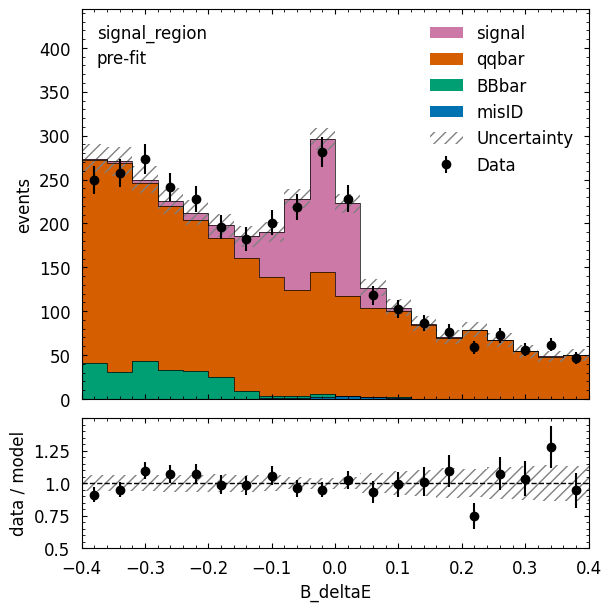

In [13]:
_ = cabinetry.visualize.data_mc_from_histograms(config)

`cabinetry` will automatically save this image in a `/figures` folder.

# Adding systematics

We now want to make our model more realistic by adding systematic uncertainties.

## Background normalization

We already normalized our model correctly to the data above. Our parameter of interest, the signal strength, is an unconstrained normalization. We want to constrain the background normalizations, since we usually believe that our modelling of these is correct within a certain uncertainty. The tightness of these constraints is very case dependent. Here we chose a very liberal backround normalization constraint of 50%.

In [14]:
norm_sys = [
      {
         'Name': 'norm_qqbar',
         'Samples': 'qqbar',
         "Up": {"Normalization": 0.5},
         "Down": {"Normalization": -0.5},
         "Type": "Normalization"
      },
      {
         'Name': 'norm_BBbar',
         'Samples': 'BBbar',
         "Up": {"Normalization": 0.5},
         "Down": {"Normalization": -0.5},
         "Type": "Normalization"
      },
      {
         'Name': 'norm_misID',
         'Samples': 'misID',
         "Up": {"Normalization": 0.5},
         "Down": {"Normalization": -0.5},
         "Type": "Normalization"
      },
   ]


## Tracking efficiency

We rerun the reconstruction, removing some tracks. The resulting ntuples contain slightly different yields which tell us about the systematic uncertainty due to the tracking efficiency. 

In `cabinetry`, adding these uncertainties is very easy. We just specify the up- and down-variations via the new `root` file. Here we tell the configuration to symmetrize the variation. Other settings, such as `Tree, Weight, Variable, Filter,...` are inherited (see https://cabinetry.readthedocs.io/en/latest/config.html#template).

The `NormPlusShape` corresponds to a `histosys` modifier plus a `normsys` modifier. The `histosys` modifier takes care of the normalized shape variation due to our new samples and the `normsys` modifier takes care of the normalization differences of our nomial sample and the the modified one. `Cabinetry` will give the modifiers the same name, which will tell `pyhf` that these modifiers are correlated. Hence we will only see 1 nuisance parameter per sample in this case.



In [15]:
tracking_sys = [
      {
         'Name':'TrackingEfficiency_signal',
         'Up': {
               'SamplePath': 'signal_rmt.root'
               },
         'Down': {'Symmetrize': True},
         'Samples': 'signal',
         'Type': 'NormPlusShape'
      },
      {
         'Name':'TrackingEfficiency_qqbar',
         'Up': {
               'SamplePath': ['ssbar_rmt.root', 'ccbar_rmt.root']
               },
         'Down': {'Symmetrize': True},
         'Samples': 'qqbar',
         'Type': 'NormPlusShape'
      },
      {
         'Name':'TrackingEfficiency_BBbar',
         'Up': {
               'SamplePath': ['charged_rmt.root', 'mixed_rmt.root'] 
               },
         'Down': {'Symmetrize': True},
         'Samples': 'BBbar',
         'Type': 'NormPlusShape'
      },
      {
         'Name':'TrackingEfficiency_misID',
         'Up': {
               'SamplePath': 'misID_rmt.root'
               },
         'Down': {'Symmetrize': True},
         'Samples': 'misID',
         'Type': 'NormPlusShape'
      }
   ]

Let us add the normalization and tracking efficiency systematics to our configuration.

In [16]:
config.update({
   'Systematics': norm_sys + tracking_sys
})
cabinetry.templates.build(config, method='uproot')

DEBUG - cabinetry.route -   in region signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample signal
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal.npz
DEBUG - cabinetry.route -       variation TrackingEfficiency_signal Up
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_signal_TrackingEfficiency_signal_Up.npz
DEBUG - cabinetry.route -     reading sample qqbar
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar.npz
DEBUG - cabinetry.route -       variation TrackingEfficiency_qqbar Up
DEBUG - cabinetry.histo - saving histogram to histograms/signal_region_qqbar_TrackingEfficiency_qqbar_Up.npz
DEBUG - cabinetry.route -     reading sam

## PID systematics

The PID systematics are not event-dependent, but bin-dependent. Adding bin-by-bin weights is not a feature that is implemented in `cabinetry` yet, so it is easier to add these systematics to the `pyhf` model directly. We will discuss this shortly, after we used cabinetry to build our `pyhf` model.

# Building a `pyhf` workspace

We now construct a `pyhf` workspace, which contains everything to build our likelihood function. This can also be used as an input file for `pyhf`. 

In [17]:
workspace_path = 'b2kpi_workspace.json'
spec = cabinetry.workspace.build(config)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor mu to sample signal in region signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys TrackingEfficiency_signal to sample signal in region signal_region
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_signal_TrackingEfficiency_signal_Up_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - normalization impact of systematic TrackingEfficiency_signal on sample signal in region signal_region is 0.992
DEBUG - cabinetry.workspace - adding OverallSys norm_qqbar to sample qqbar in region signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys TrackingEfficiency_qqbar to sample qqbar in region signal_region
WARNING - cabinetry.histo - the modified histogram histograms/signal_region_qqbar_TrackingEfficiency_qqbar_Up_modified.npz does not exist
WARNING - cabinet

## Adding PID systematics

The systematics on the PID weights are stored in the `pid_systematics.csv` file. This is nothing but a table, split up by sample and fitting bin.
Hence, the systematics depend on our choice of binning. The type `u` corresponds to uncorrelated uncertainties and the `c` types correspond to correlated ones.

In [18]:
pid_sys = pd.read_csv('pid-tables/pid_systematics.csv')
pid_types = pid_sys.filter(regex=r'type')
pid_sig = pid_sys.filter(regex=r'signal*')
pid_sys

,type,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,misID_11,misID_12,misID_13,misID_14,misID_15,misID_16,misID_17,misID_18,misID_19,misID_20
0,u,0.062,0.063,0.054,0.064,0.042,0.037,0.027,0.015,0.010,...,0.016,0.026,0.178,0.381,0.808,0.647,0.632,1.506,2.935,1.559
1,c1,-0.041,-0.033,-0.026,-0.015,-0.015,-0.008,0.000,0.000,0.002,...,-0.004,-0.003,0.080,0.101,0.370,0.029,-0.033,-0.045,0.065,0.619
2,c2,-0.001,-0.002,-0.000,-0.002,-0.001,-0.001,-0.001,0.000,0.001,...,0.054,0.011,-0.212,-0.498,-0.801,-0.159,0.447,0.408,1.092,-0.917
3,c3,0.006,0.004,0.004,0.005,0.004,0.004,0.003,0.003,0.003,...,-0.050,0.249,0.733,0.812,1.090,0.659,-0.164,0.006,0.615,0.566
4,c4,-0.145,-0.143,-0.149,-0.146,-0.156,-0.162,-0.165,-0.172,-0.176,...,0.003,0.031,0.089,0.113,0.136,0.004,-0.066,-0.162,-0.031,-0.020
5,c5,-0.009,-0.007,-0.006,-0.009,-0.010,-0.011,-0.012,-0.013,-0.014,...,-1.928,-1.992,-2.131,-2.151,-2.225,-1.969,-1.787,-1.485,-1.371,-1.811


Now we add the systematics directly to the `pyhf` model. The uncorrelated part, we add as a `staterror` type, because this reduced the number of nuisance parameters. The correlated uncertainties we add as `histosys` modifiers, by specifying the up and down variation of the yields. 

In [19]:
def add_quadrature(a,b):
    return np.sqrt(np.add(np.power(a, 2),np.power(b, 2)).tolist())
    
# loop over variations
for _ , var in pid_sys.iterrows():
    # loop over samples
    for sam in spec['channels'][0]['samples']:
        name   = sam['name']
        yields = sam['data']
        variation = var.filter(regex=rf'{name}*').to_numpy()
        #apply variations according to type
        if var.type=='u':
            sam['modifiers'].append(
                {   
                    'name': f'pid_sys_{var.type}',
                    'type': 'staterror',
                    'data': list(variation)
                }
            )
        else:
            sam['modifiers'].append(
                {   
                    'name': f'pid_sys_{var.type}',
                    'type': 'histosys',
                    'data': {
                            'hi_data': list(yields*(1+variation)),
                            'lo_data': list(yields*(1-variation))
                            }
                }
            )

We can now print our workspace and inspect it.

In [20]:
cabinetry.workspace.save(spec, workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

DEBUG - cabinetry.workspace - saving workspace to b2kpi_workspace.json


{
    "channels": [
        {
            "name": "signal_region",
            "samples": [
                {
                    "data": [
                        1.3670679286616694,
                        2.1422290835974427,
                        3.25908208248412,
                        4.95924980004079,
                        8.077926713140087,
                        14.26866248036101,
                        24.864161232780464,
                        51.16670643781338,
                        103.77054704031733,
                        151.84082888347893,
                        105.18639524888813,
                        23.4027409747863,
                        3.4397688968787667,
                        1.0415074282717847,
                        0.5274508575561043,
                        0.20424409867281734,
                        0.18144720776431666,
                        0.08304605867480283,
                        0.07178317909278627,
                        0.044

## Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues. The `visualize.modifier_grid` function creates a figure showcasing the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c1 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c2 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c3 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c4 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c5 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf 

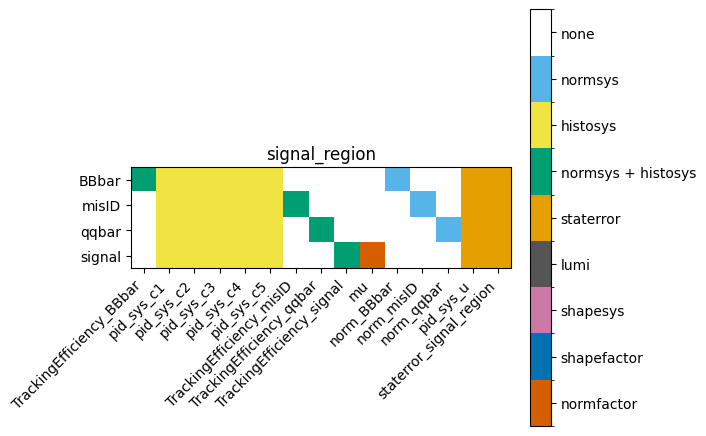

In [21]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

# Performing statistical inference

To perform inference, we need two things: a probability density function (pdf), or `model`, and data to fit it to. Both are derived from the workspace specification.

In [22]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier TrackingEfficiency_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c1 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c2 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c3 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c4 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier pid_sys_c5 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_misID (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_qqbar (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier TrackingEfficiency_signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier norm_BBbar (1 new nuisance parameters)
INFO - pyhf.pdf 

We see that all the modifiers that we defined for our model appear here.

## Validating the tracking efficiency systematics 

First let us check that we indeed only get 1 nuisance parameter per sample for the `TrackingEfficiency` modifier:

In [23]:
model.config.par_names

['TrackingEfficiency_BBbar',
 'pid_sys_c1',
 'pid_sys_c2',
 'pid_sys_c3',
 'pid_sys_c4',
 'pid_sys_c5',
 'TrackingEfficiency_misID',
 'TrackingEfficiency_qqbar',
 'TrackingEfficiency_signal',
 'mu',
 'norm_BBbar',
 'norm_misID',
 'norm_qqbar',
 'pid_sys_u[0]',
 'pid_sys_u[1]',
 'pid_sys_u[2]',
 'pid_sys_u[3]',
 'pid_sys_u[4]',
 'pid_sys_u[5]',
 'pid_sys_u[6]',
 'pid_sys_u[7]',
 'pid_sys_u[8]',
 'pid_sys_u[9]',
 'pid_sys_u[10]',
 'pid_sys_u[11]',
 'pid_sys_u[12]',
 'pid_sys_u[13]',
 'pid_sys_u[14]',
 'pid_sys_u[15]',
 'pid_sys_u[16]',
 'pid_sys_u[17]',
 'pid_sys_u[18]',
 'pid_sys_u[19]',
 'staterror_signal_region[0]',
 'staterror_signal_region[1]',
 'staterror_signal_region[2]',
 'staterror_signal_region[3]',
 'staterror_signal_region[4]',
 'staterror_signal_region[5]',
 'staterror_signal_region[6]',
 'staterror_signal_region[7]',
 'staterror_signal_region[8]',
 'staterror_signal_region[9]',
 'staterror_signal_region[10]',
 'staterror_signal_region[11]',
 'staterror_signal_region[12]',


Next we want to verify the numeric variations for the signal region.
To check these variations, we load the signal region Up-variation histogram for the `TrackingEfficiency`, which corresponds to the yields of the modified sample. To compare, we also load the nominal yields.

In [24]:
tracking_nominal = np.load('histograms/signal_region_signal.npz')['yields']
tracking_modified = np.load('histograms/signal_region_signal_TrackingEfficiency_signal_Up.npz')['yields']

First let us check the `normsys` variations. We expect:

In [25]:
spec['channels'][0]['samples'][0]['modifiers'][2]

{'name': 'TrackingEfficiency_signal',
 'type': 'normsys',
 'data': {'hi': 0.9920460486082363, 'lo': 1.0079539513917637}}

Here `hi` and `lo` are just labels for the numbers we interpolate between. It does not matter if `lo` is larger than `hi`.

We can calculate these values as the ratio of the total number of (possibly weighted) events. Make sure you understand the origin of these numbers.

In [26]:
sum(tracking_modified)/sum(tracking_nominal)

0.9920460486082363

In [27]:
(2*sum(tracking_nominal) - sum(tracking_modified))/sum(tracking_nominal)

1.0079539513917637

Now let us check the `histosys` entries. We expect

In [28]:
spec['channels'][0]['samples'][0]['modifiers'][3]

{'name': 'TrackingEfficiency_signal',
 'type': 'histosys',
 'data': {'hi_data': [1.3635903410892407,
   2.1594048850885743,
   3.2127818910973267,
   4.938806446719716,
   8.042385063581785,
   14.312335201994824,
   24.854424289695793,
   51.20871268857808,
   103.57364189030864,
   151.8377343509697,
   105.28451620699954,
   23.485167520961042,
   3.4545982973967484,
   1.0498579473532896,
   0.5316798129442448,
   0.20588167148022612,
   0.1829020013928517,
   0.08371189905076484,
   0.0723587168090559,
   0.044570268556136536],
  'lo_data': [1.370545516234098,
   2.125053282106311,
   3.305382273870913,
   4.979693153361864,
   8.11346836269839,
   14.224989758727197,
   24.873898175865136,
   51.12470018704868,
   103.96745219032601,
   151.84392341598817,
   105.08827429077672,
   23.32031442861156,
   3.424939496360785,
   1.0331569091902797,
   0.5232219021679638,
   0.20260652586540856,
   0.17999241413578163,
   0.08238021829884082,
   0.07120764137651664,
   0.0438612490569

We calculate these numbers by calculating the differenced of the nominal yields to the correctly scaled modified ones.

In [29]:
scale = sum(tracking_modified)/sum(tracking_nominal)
tracking_modified/scale

array([1.36359034e+00, 2.15940489e+00, 3.21278189e+00, 4.93880645e+00,
       8.04238506e+00, 1.43123352e+01, 2.48544243e+01, 5.12087127e+01,
       1.03573642e+02, 1.51837734e+02, 1.05284516e+02, 2.34851675e+01,
       3.45459830e+00, 1.04985795e+00, 5.31679813e-01, 2.05881671e-01,
       1.82902001e-01, 8.37118991e-02, 7.23587168e-02, 4.45702686e-02])

In [30]:
2*tracking_nominal - tracking_modified / scale

array([1.37054552e+00, 2.12505328e+00, 3.30538227e+00, 4.97969315e+00,
       8.11346836e+00, 1.42249898e+01, 2.48738982e+01, 5.11247002e+01,
       1.03967452e+02, 1.51843923e+02, 1.05088274e+02, 2.33203144e+01,
       3.42493950e+00, 1.03315691e+00, 5.23221902e-01, 2.02606526e-01,
       1.79992414e-01, 8.23802183e-02, 7.12076414e-02, 4.38612491e-02])

Can you explain the origin of these formulae?

## Maximum likelihood estimate

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [31]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -89.9                      │             Nfcn = 5222              │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────────────────

The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results. 

In [32]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f'{label}: {result:.3f} +/- {unc:.3f}')

TrackingEfficiency_BBbar: 0.024 +/- 0.992
pid_sys_c1: 0.291 +/- 0.583
pid_sys_c2: -0.027 +/- 0.909
pid_sys_c3: -0.322 +/- 0.943
pid_sys_c4: -0.275 +/- 0.902
pid_sys_c5: 0.104 +/- 0.905
TrackingEfficiency_misID: 0.001 +/- 0.993
TrackingEfficiency_qqbar: 0.283 +/- 0.960
TrackingEfficiency_signal: -0.000 +/- 0.993
mu: 0.910 +/- 0.184
norm_BBbar: 0.364 +/- 0.813
norm_misID: -0.009 +/- 0.995
norm_qqbar: -0.048 +/- 0.281
pid_sys_u[0]: 1.000 +/- 0.004
pid_sys_u[1]: 1.000 +/- 0.004
pid_sys_u[2]: 1.000 +/- 0.003
pid_sys_u[3]: 1.000 +/- 0.002
pid_sys_u[4]: 1.000 +/- 0.003
pid_sys_u[5]: 1.000 +/- 0.002
pid_sys_u[6]: 1.000 +/- 0.003
pid_sys_u[7]: 1.000 +/- 0.001
pid_sys_u[8]: 1.000 +/- 0.000
pid_sys_u[9]: 1.000 +/- 0.000
pid_sys_u[10]: 1.000 +/- 0.000
pid_sys_u[11]: 1.000 +/- 0.001
pid_sys_u[12]: 1.000 +/- 0.003
pid_sys_u[13]: 1.000 +/- 0.005
pid_sys_u[14]: 1.000 +/- 0.012
pid_sys_u[15]: 0.999 +/- 0.008
pid_sys_u[16]: 1.000 +/- 0.010
pid_sys_u[17]: 1.001 +/- 0.028
pid_sys_u[18]: 1.023 +/- 0.058
pi

It is helpful to visualize the fit results. Let's start with the pull plot showing us the constrained best-fit parameter results.

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


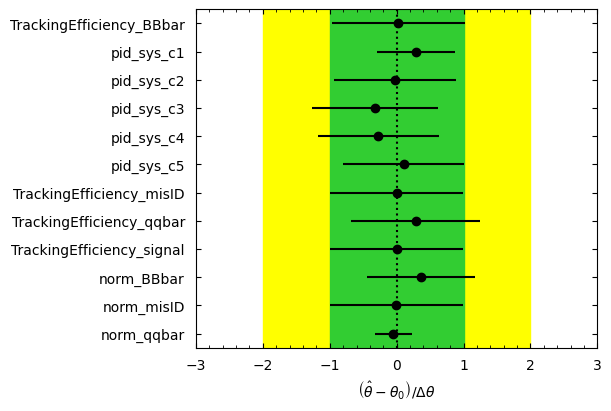

In [33]:
cabinetry.visualize.pulls(fit_results, exclude=['mu']+[l for l in fit_results.labels if 'pid_sys_u' in l])

The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


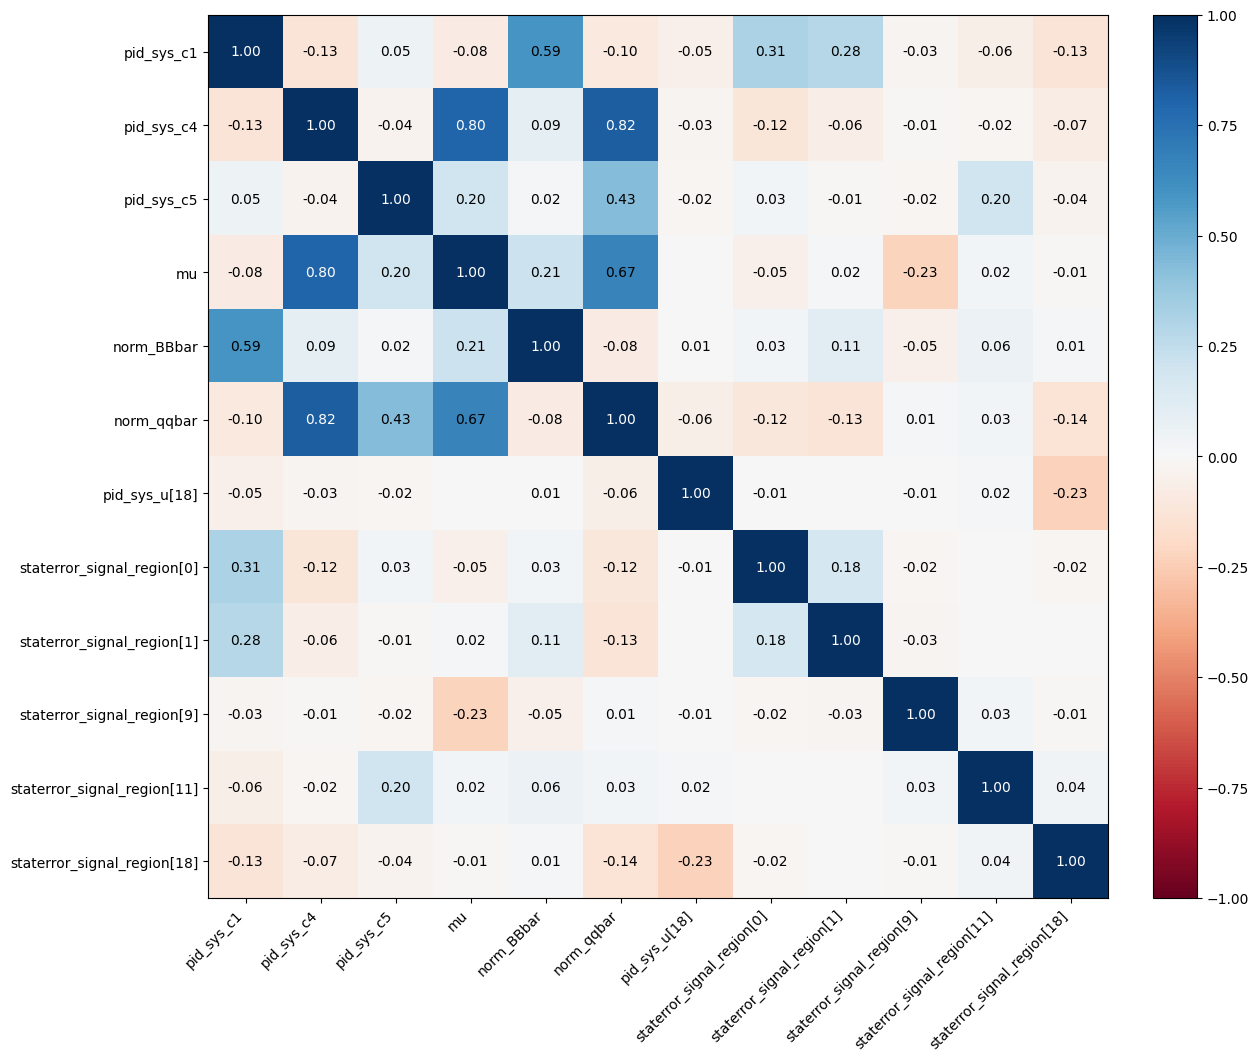

In [34]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)

Let us look at the post-fit result. This is as easy as passing `fit_results` to `cabinetry.model_utils.prediction`.

DEBUG - cabinetry.model_utils - total stdev is [[13.2, 13, 13.3, 12.1, 11.6, 10.6, ..., 6.28, 6.45, 6.33, 5.47, 5.5, 5.2]]
DEBUG - cabinetry.model_utils - total stdev per channel is [58.2]
INFO - cabinetry.visualize.utils - saving figure as figures/signal_region_postfit.pdf


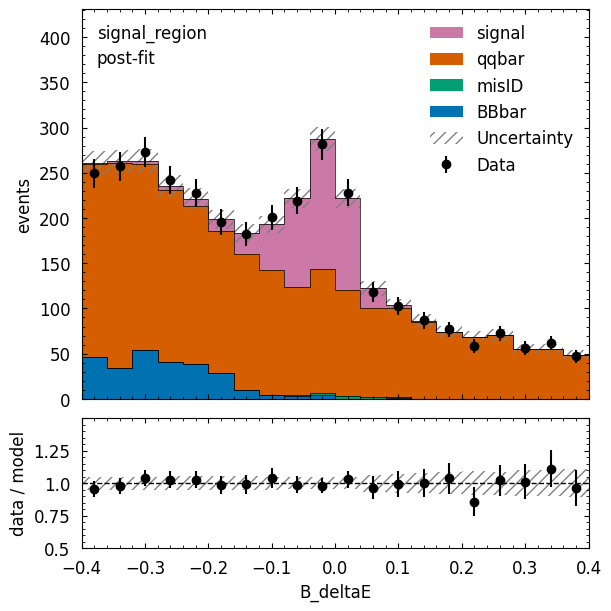

In [35]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=config)

Yield tables can also be created from a model prediction, and compared to data. Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default). The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.

In [36]:
model_pred = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_pred, data)

DEBUG - cabinetry.model_utils - total stdev is [[128, 129, 114, 103, 95.3, 87.9, 83, ..., 37.8, 42.4, 36.4, 29.5, 26.3, 27]]
DEBUG - cabinetry.model_utils - total stdev per channel is [1.36e+03]
INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒══════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│ sample   │ signal_region   │                 │                 │                 │                │                │                │                │                │                │                │                │                │               │               │               │               │               │               │               │
│          │ bin 1           │ b

**Hint for your future** (aside)\
You can change the optimizer used for minimization using\
`pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer(*args, **kwargs))`\
or\
`pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(*args, **kwargs))`.\
The `iminuit` minimizer used here can become unstable in some cases. If this happens to you, a first diagnostic test is switching to the `scipy` optimizer. This one is more stable, but will not return uncertainties on your fit parameters. If you find that `scipy` works, but `iminuit` fails, you can either try to get `iminuit` working by tuning settings such as the strategy or tolerance or fit using `scipy` first and then use the resulting best-fit parameters as input parameters to a second fit with `iminuit`.  

# More advanced features

Here we provide a list of more advanced features, for you to study if you have time. Most features are documented in one of these referenced:

* [`Cabinetry` Documentation](https://cabinetry.readthedocs.io/en/latest/index.html)
* [`Cabinetry` tutorial](https://github.com/cabinetry/cabinetry-tutorials/blob/master/example.ipynb)
* [Tutorial from Belle II `pyhf` workshop](https://github.com/alexander-held/Belle-II-cabinetry/blob/main/talk.ipynb)

## Asimov fit

If you do not have data points readily available, a good first check if your fit works properly is a fit to Asimov data. Find out what Asimov data is and how to obtain it (cabinetry can do this). Then perform a fit to the Asimov data and see if you obtain what you expect.

## Likelihood scan

Perform a likelihood scan of our POI. This will tell you about the (asymmetric) uncertainty of the parameter. Does it agree with the uncertainty obtained in the fit above? It will also tell you if your likelihood scan agrees well with a Gaussian approximation. Does it in this case? Can you explain why?

## Parameter ranking

We can rank nuisance parameters by their impact on the POI: how much does the POI change if the NP varies within its uncertainty? How is this determined? (This requires a lot of MLE fits.)
